overall, using K's architecture instead of local PCN, we can achieve same type qualitative conclusions: more cycles -> better performance.

In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product, chain

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
# I forgot how this count_params handles BN buffer parameters (running mean and std) looks like it's ignored.
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import load_modules

load_modules()

In [4]:
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200218 as param_iterator_obj,
    explored_models_20200430 as param_iterator_obj_smaller_training_data,
    explored_models_20200520 as param_iterator_obj_more_cls,
    explored_models_20200616 as param_iterator_obj_even_more_cls,
    keygen
)

In [5]:
# compute ccmax
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)

In [6]:
from functools import partial
strategy_to_try_dict = {
    'original': None,
    # for debugging. should be equal to original.
    'cummean_last': {
        'yhat_reduce_pick': -1,
    },
    'cummean_none': {
        'yhat_reduce_pick': 'none',
    },
}



In [7]:
from thesis_v2.training_extra.data import generate_datasets
from thesis_v2.training_extra.evaluation import eval_fn_wrapper as eval_fn_wrapper_neural
from thesis_v2.training.training import eval_wrapper
from thesis_v2.data.prepared.yuanyuan_8k import get_data, get_neural_data

In [8]:
# copied from maskcnn_polished_with_rcnn_k_bl/store_response_for_20200218.ipynb

from torch.backends import cudnn
import torch
cudnn.enabled = True
cudnn.deterministic = True
cudnn.benchmark = False

_data_cache = dict()

def get_data_cached(input_size, seed):
    if (input_size, seed) not in _data_cache:
        _data_cache[input_size, seed] = get_data('a', 200, input_size,
                                                 ('042318', '043018', '051018'),
                                                 scale=0.5,
                                                 seed=seed)
    return _data_cache[input_size, seed]


def evaluate_one_model_using_one_strategy(datasets_test, model, param, loss_type):
    
    # set model param    
    result_on_the_go = eval_wrapper(model,
                                    datasets_test,
                                    'cuda',
                                    1,
                                    partial(eval_fn_wrapper_neural, loss_type=loss_type, yhat_reduce_axis=1,
                                            yhat_reduce_pick=param['yhat_reduce_pick']),
                                    (lambda dummy1,dummy2,dummy3: torch.tensor(0.0)),
                                    return_responses=False,
                                   )
    ret = np.asarray(result_on_the_go['corr'])
    return ret

In [9]:
def load_everything():
    _df_collect = []
    for idx, param in enumerate(
        chain(
            param_iterator_obj().generate(),
            param_iterator_obj_smaller_training_data().generate(),
            param_iterator_obj_more_cls().generate(),
            param_iterator_obj_even_more_cls().generate(),
        )
    ):
        if idx % 100 == 0:
            print(idx)
            
#         if idx >= 100:
#             break
            
#         print(len(param))
#         print(len(param))

        if param['kernel_size_l23'] != 3:
            continue

        if len(param) == 22:
            param['train_keep'] = None
        assert len(param) == 23
        
        assert param['kernel_size_l1'] == 9
        assert param['ff_1st_block']
        
        
        
        assert param['split_seed'] == 'legacy'
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        assert not param['bn_after_fc']
        assert param['rcnn_bl_psize'] == 1
        assert param['rcnn_bl_ptype'] is None
        assert param['input_size'] == 50
        
        # 12 to go
        # remove smoothness_name and scale_name, 10 to go
        
#         assert param['model_seed'] == 0
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (79,)
        
        if param['train_keep'] is None:
            param['train_keep'] = 5120
            
            
        model = result['model']
        model.cuda()
        model.eval()
        datasets = get_data_cached(param['input_size'], param['split_seed'])
        datasets = {
            'X_train': datasets[0].astype(np.float32),
            'y_train': datasets[1],
            'X_val': datasets[2].astype(np.float32),
            'y_val': datasets[3],
            'X_test': datasets[4].astype(np.float32),
            'y_test': datasets[5],
        }
        
        # only the test one is needed.
        datasets_test = generate_datasets(
            **datasets,
            per_epoch_train=False,
            shuffle_train=False,
        )['test']
        
        
        for strategy, strategy_params in strategy_to_try_dict.items():
            if strategy == 'original':
                cc_raw_this = cc_raw
            else:
                cc_raw_this = evaluate_one_model_using_one_strategy(datasets_test, model, strategy_params, param['loss_type'])
            assert cc_raw_this.shape == (79,)
            _df_collect.append(
            {
                'train_keep': param['train_keep'],
                'act_fn': param['act_fn'],
                'loss_type': param['loss_type'],
                'scale': float(param['scale']),
                'smoothness': float(param['smoothness']),
                'num_layer': param['num_layer'],
                'out_channel': param['out_channel'],
                # 4 to go.
                '1st_bn_before_act': param['ff_1st_bn_before_act'],
                'rcnn_bl_cls': param['rcnn_bl_cls'],
                'rcnn_acc_type': param['rcnn_acc_type'],

                'model_seed': param['model_seed'],
                'strategy': strategy,
                # done,
                'corr_test': ((cc_raw_this/cc_max_all_neurons)**2).mean(),
                'max_epoch': max(num_epochs),
                'num_param': count_params(result['model']),
            })
            
    _df = pd.DataFrame(_df_collect, columns=[
#             'split_seed',
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',

        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'model_seed',
        'strategy',
        'corr_test',
        'num_param',
        'max_epoch',
    ])
#     print(_df)
    _df = _df.set_index([
        'train_keep',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',
        'rcnn_bl_cls',
#         'rcnn_acc_type',
        'strategy',
        'model_seed',
    ], verify_integrity=True)
    return _df

In [10]:
df = load_everything()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000


In [11]:
corr_mean = df['corr_test'].unstack('model_seed').mean(axis=1)

# mean, max, min, all the same. for num_param
num_param = df['num_param'].unstack('model_seed').mean(axis=1)

In [12]:
from IPython.display import display

In [13]:
# let's try to quickly eliminate bad configs, just like before, by plotting scatter plots.
def scatter(x, y, xlabel, ylabel, title):
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
    print('y top', y.max(), 'x top', x.max())

In [14]:
# here, I need to check the effective ness of act_fn, bn_before_act, bn_after_fc, loss_type
def check_compare_one_case(series_in, label_to_unstack, values_to_check=None):
    df_unstacked = series_in.unstack(label_to_unstack)
#     assert df_unstacked.shape[1] == 2
    if values_to_check is None:
        values_to_check = df_unstacked.columns.values[:2].tolist()
    else:
        pass
    
    assert len(values_to_check) == 2
    label_x = values_to_check[0]
    label_y = values_to_check[1]
        
    data_x = df_unstacked.loc[:,label_x].values
    data_y = df_unstacked.loc[:,label_y].values
    
    
    
    scatter(data_x, data_y, str(label_x), str(label_y), f'{label_to_unstack}: {label_y} vs {label_x}')

original
(48, 10)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n 48
2 - 1 mean 0.029584268475115222 sem 0.0023691908064684014
3 - 2 mean 0.005058711595277207 sem 0.0011520950345487745
4 - 3 mean 0.002843366782809708 sem 0.0008682186522390155
4 - 2 mean 0.007902078378086916 sem 0.0013188904547508022


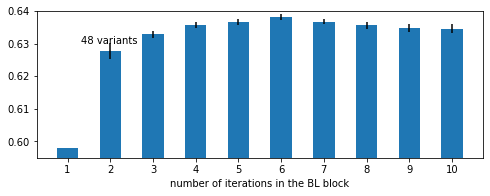

[0.5981444926019676, 0.6277287610770829, 0.63278747267236, 0.6356308394551697, 0.6364964820075983, 0.6381282988395233, 0.636692609321775, 0.6356026393465307, 0.6348428626016055, 0.6345055366352274] [ 4.946007    0.80587539  0.44933993  0.13618637  0.25637484 -0.22498446
 -0.1711925  -0.11953644 -0.05313535]


,num_of_cycles,performance,gain %
0,1,0.598144,NaN
1,2,0.627729,4.946007
2,3,0.632787,0.805875
3,4,0.635631,0.449340
4,5,0.636496,0.136186
5,6,0.638128,0.256375
6,7,0.636693,-0.224984
7,8,0.635603,-0.171192
8,9,0.634843,-0.119536
9,10,0.634506,-0.053135


cummean_last
(48, 10)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n 48
2 - 1 mean 0.02958426882002964 sem 0.002369190849576563
3 - 2 mean 0.005058711945235587 sem 0.0011520949891700844
4 - 3 mean 0.0028433666523148965 sem 0.0008682186694112647
4 - 2 mean 0.007902078597550483 sem 0.0013188904662575548


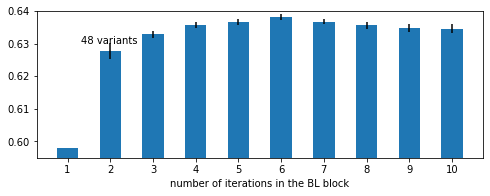

[0.5981444918434642, 0.6277287606634938, 0.6327874726087295, 0.6356308392610444, 0.6364964817875943, 0.6381282986122634, 0.6366926093193942, 0.6356026390528444, 0.6348428626065278, 0.6345055368950182] [ 4.94600706  0.80587545  0.44933991  0.13618636  0.25637484 -0.22498443
 -0.17119254 -0.11953639 -0.05313531]


,num_of_cycles,performance,gain %
0,1,0.598144,NaN
1,2,0.627729,4.946007
2,3,0.632787,0.805875
3,4,0.635631,0.449340
4,5,0.636496,0.136186
5,6,0.638128,0.256375
6,7,0.636693,-0.224984
7,8,0.635603,-0.171193
8,9,0.634843,-0.119536
9,10,0.634506,-0.053135


cummean_none
(48, 10)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n 48
2 - 1 mean 0.018206697219185445 sem 0.0016420386068309895
3 - 2 mean 0.006269487525356975 sem 0.0011806503753137136
4 - 3 mean 0.005090623074292794 sem 0.0008977572464320788
4 - 2 mean 0.011360110599649769 sem 0.001366601285288803


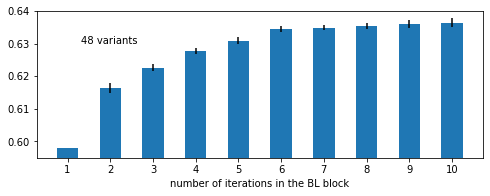

[0.5981444918434642, 0.6163511890626496, 0.6226206765880066, 0.6277112996622994, 0.630924480365781, 0.634459544208008, 0.634901263847815, 0.6353606147985426, 0.6359237434053786, 0.6363850491767863] [3.04386272 1.01719403 0.81761227 0.5118883  0.56029905 0.0696214
 0.07234998 0.08863134 0.07254105]


,num_of_cycles,performance,gain %
0,1,0.598144,NaN
1,2,0.616351,3.043863
2,3,0.622621,1.017194
3,4,0.627711,0.817612
4,5,0.630924,0.511888
5,6,0.634460,0.560299
6,7,0.634901,0.069621
7,8,0.635361,0.072350
8,9,0.635924,0.088631
9,10,0.636385,0.072541


In [15]:
def plot_step_increase(df_this, pairs_to_check, ylim):
    # remove those no innner act ones.
    df_unstacked = df_this.unstack('rcnn_bl_cls')
#     df_unstacked = corr_mean.unstack('pcn_cls')
    print(df_unstacked.shape)
    
#     selector = df_unstacked.values[:,0] >= 0.50
    selector = ()
#     print(selector.mean())
    
    cls_values = df_unstacked.columns.values.tolist()
    print(cls_values)
    assert cls_values == list(range(1,len(cls_values)+1))
    
    n = df_unstacked.shape[0]
    
#     n = selector.sum()
    print('n', n)
    
    
    for p1, p2 in pairs_to_check:
        val0 = df_unstacked.values[:,p1-1][selector]
        val1 = df_unstacked.values[:,p2-1][selector]

        # selection
        print(
            f'{p2} - {p1}',
            'mean', (val1-val0).mean(),
            'sem', (val1-val0).std()/np.sqrt(n)
        )
        
    # time to plot.
    # show results for cls_values[0] through cls_values[-1]
    # for the first one, just show mean,
    # for others show mean and s.e.m. of increase.
    
    mean_performance = []
    sem_increase = []
    labels = []
    
    for idx, cls_name in enumerate(cls_values):
        assert idx == cls_name - 1
        mean_performance.append(df_unstacked.values[:,idx][selector].mean())
        if idx == 0:
            sem_increase.append(0.0)
        else:
            sem_increase.append((df_unstacked.values[:,idx][selector]-df_unstacked.values[:,idx-1][selector]).std()/np.sqrt(n))
        labels.append(str(cls_name))
        
    
    plt.close('all')
    fig = plt.figure(figsize=(8,3))
    plt.bar(np.arange(len(cls_values)), mean_performance, 0.5, yerr=sem_increase)
#     plt.ylabel('neural prediction performance')
    plt.ylim(*ylim)
    plt.xlabel('number of iterations in the BL block')
    plt.xticks(np.arange(len(cls_values)), labels)
    
    
    plt.text(0.1, 0.8, f'{n} variants', verticalalignment='center', horizontalalignment='left', transform=plt.gca().transAxes)
    fig.subplots_adjust(bottom=0.2)

    plt.show()
    
    print(mean_performance, np.diff(mean_performance)/mean_performance[:-1]*100)
    
    return pd.DataFrame(
        data = {
            'num_of_cycles': cls_values,
            'performance': mean_performance,
            'gain %': np.concatenate([np.asarray([np.nan]),  np.diff(mean_performance)/mean_performance[:-1]*100])
        },
        columns = ['num_of_cycles', 'performance', 'gain %']
    )
    
    
    
# trend for 0-1-2 is good. then bad.
for strategy_to_try_this in strategy_to_try_dict:
    print(strategy_to_try_this)
    display(plot_step_increase(corr_mean.xs(5120, level='train_keep').xs(strategy_to_try_this, level='strategy'),
                               [(1,2),(2,3),(3,4),(2,4)], (0.595, 0.64)))

original
(48, 10)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n 48
2 - 1 mean 0.03213541874850471 sem 0.0025766177900937983
3 - 2 mean 0.008347088783902957 sem 0.0015108716698198836
4 - 3 mean 0.0018157022521956047 sem 0.0011304202308431818
4 - 2 mean 0.01016279103609856 sem 0.0017724249861233421


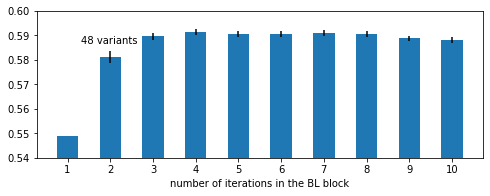

[0.5490784455163847, 0.5812138642648894, 0.5895609530487924, 0.591376655300988, 0.5904544316274594, 0.5907049231374611, 0.590807603380315, 0.5907289117768241, 0.5888142268133377, 0.5879780295417077] [ 5.85260977  1.43614757  0.30797532 -0.15594523  0.04242351  0.01738266
 -0.01331933 -0.32412244 -0.14201377]


,num_of_cycles,performance,gain %
0,1,0.549078,NaN
1,2,0.581214,5.852610
2,3,0.589561,1.436148
3,4,0.591377,0.307975
4,5,0.590454,-0.155945
5,6,0.590705,0.042424
6,7,0.590808,0.017383
7,8,0.590729,-0.013319
8,9,0.588814,-0.324122
9,10,0.587978,-0.142014


cummean_last
(48, 10)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n 48
2 - 1 mean 0.0321354188268075 sem 0.002576617848997157
3 - 2 mean 0.008347088681131376 sem 0.0015108716770824444
4 - 3 mean 0.0018157024358895768 sem 0.0011304202383880717
4 - 2 mean 0.010162791117020953 sem 0.0017724250447607945


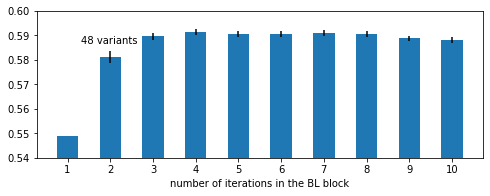

[0.5490784449504361, 0.5812138637772436, 0.589560952458375, 0.5913766548942646, 0.5904544312897737, 0.590704923032409, 0.5908076030609083, 0.5907289113983042, 0.5888142265827553, 0.5879780294329867] [ 5.85260979  1.43614755  0.30797535 -0.15594522  0.04242355  0.01738263
 -0.01331934 -0.32412242 -0.14201375]


,num_of_cycles,performance,gain %
0,1,0.549078,NaN
1,2,0.581214,5.852610
2,3,0.589561,1.436148
3,4,0.591377,0.307975
4,5,0.590454,-0.155945
5,6,0.590705,0.042424
6,7,0.590808,0.017383
7,8,0.590729,-0.013319
8,9,0.588814,-0.324122
9,10,0.587978,-0.142014


cummean_none
(48, 10)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n 48
2 - 1 mean 0.02127080170190541 sem 0.0020422225871147026
3 - 2 mean 0.010066026727597833 sem 0.001517881582494334
4 - 3 mean 0.004064632926681816 sem 0.0011396326028277563
4 - 2 mean 0.014130659654279648 sem 0.0018625836399771398


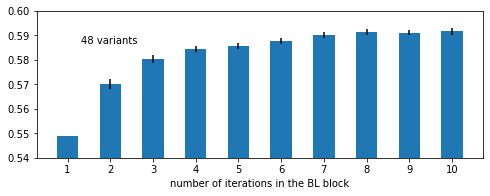

[0.5490784449504361, 0.5703492466523415, 0.5804152733799395, 0.5844799063066212, 0.5855832477158295, 0.5877366922349889, 0.5901162280519158, 0.5914963345864573, 0.5911734548661783, 0.5916135266961843] [ 3.87390944  1.76488823  0.70029738  0.1887732   0.36774353  0.40486426
  0.23387029 -0.05458694  0.07444039]


,num_of_cycles,performance,gain %
0,1,0.549078,NaN
1,2,0.570349,3.873909
2,3,0.580415,1.764888
3,4,0.584480,0.700297
4,5,0.585583,0.188773
5,6,0.587737,0.367744
6,7,0.590116,0.404864
7,8,0.591496,0.233870
8,9,0.591173,-0.054587
9,10,0.591614,0.074440


In [16]:
for strategy_to_try_this in strategy_to_try_dict:
    print(strategy_to_try_this)
    display(plot_step_increase(corr_mean.xs(2560, level='train_keep').xs(strategy_to_try_this, level='strategy'),
                               [(1,2),(2,3),(3,4),(2,4)], (0.54, 0.60)))

original
(48, 10)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n 48
2 - 1 mean 0.04523365574800469 sem 0.005037852949246889
3 - 2 mean 0.013131153779203972 sem 0.002878739887091527
4 - 3 mean 0.005734356768863336 sem 0.002358048753461559
4 - 2 mean 0.01886551054806731 sem 0.004194165900711485


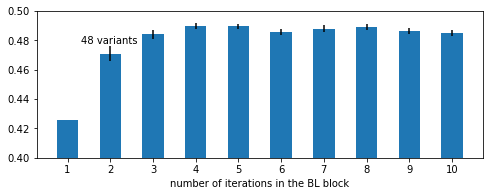

[0.425658276964285, 0.47089193271228974, 0.48402308649149367, 0.48975744326035703, 0.4894989677010478, 0.4856686831073271, 0.4878747808122899, 0.4891535687737521, 0.4865969489321256, 0.48492418069923104] [10.62675348  2.78857055  1.18472795 -0.05277624 -0.78249084  0.45423923
  0.26211397 -0.522662   -0.34376875]


,num_of_cycles,performance,gain %
0,1,0.425658,NaN
1,2,0.470892,10.626753
2,3,0.484023,2.788571
3,4,0.489757,1.184728
4,5,0.489499,-0.052776
5,6,0.485669,-0.782491
6,7,0.487875,0.454239
7,8,0.489154,0.262114
8,9,0.486597,-0.522662
9,10,0.484924,-0.343769


cummean_last
(48, 10)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n 48
2 - 1 mean 0.0452336559376855 sem 0.005037852920954537
3 - 2 mean 0.013131153667870389 sem 0.002878739922450035
4 - 3 mean 0.005734357210287383 sem 0.002358048757734154
4 - 2 mean 0.01886551087815777 sem 0.00419416597801228


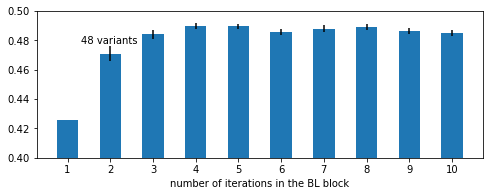

[0.4256582768579114, 0.470891932795597, 0.48402308646346737, 0.4897574436737547, 0.48949896923790753, 0.48566868304282823, 0.4878747807519934, 0.4891535688365902, 0.48659694904977685, 0.48492418063955683] [10.62675352  2.78857053  1.18472804 -0.05277601 -0.78249117  0.45423923
  0.262114   -0.52266199 -0.34376878]


,num_of_cycles,performance,gain %
0,1,0.425658,NaN
1,2,0.470892,10.626754
2,3,0.484023,2.788571
3,4,0.489757,1.184728
4,5,0.489499,-0.052776
5,6,0.485669,-0.782491
6,7,0.487875,0.454239
7,8,0.489154,0.262114
8,9,0.486597,-0.522662
9,10,0.484924,-0.343769


cummean_none
(48, 10)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
n 48
2 - 1 mean 0.03473481802161608 sem 0.0045940460138639205
3 - 2 mean 0.014412588788527511 sem 0.0028488199055806966
4 - 3 mean 0.007887165509076024 sem 0.0023575591268929406
4 - 2 mean 0.02229975429760354 sem 0.004125919932353227


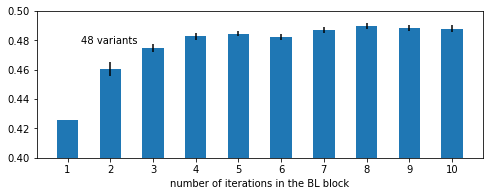

[0.4256582768579114, 0.4603930948795276, 0.474805683668055, 0.4826928491771311, 0.48443213967375026, 0.4822901128592716, 0.4870891443149412, 0.4898507848550024, 0.4885316163002855, 0.48793878599371515] [ 8.16025904  3.1304963   1.66113545  0.36033069 -0.44217273  0.99505076
  0.5669682  -0.26930008 -0.12134942]


,num_of_cycles,performance,gain %
0,1,0.425658,NaN
1,2,0.460393,8.160259
2,3,0.474806,3.130496
3,4,0.482693,1.661135
4,5,0.484432,0.360331
5,6,0.482290,-0.442173
6,7,0.487089,0.995051
7,8,0.489851,0.566968
8,9,0.488532,-0.269300
9,10,0.487939,-0.121349


In [17]:
for strategy_to_try_this in strategy_to_try_dict:
    print(strategy_to_try_this)
    display(plot_step_increase(corr_mean.xs(1280, level='train_keep').xs(strategy_to_try_this, level='strategy'),
                               [(1,2),(2,3),(3,4),(2,4)], (0.4, 0.5)))

In [18]:
# check relationship between num_param and performance, colored for different num_of_cycles.